In [24]:
import torch
import os
import rasterio
import yaml
from train import create_dataloader
import numpy as np
import matplotlib.pyplot as plt
from model import CustomResNet
from torch.nn.functional import softmax
from torch.utils.data import DataLoader
import pandas as pd
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore",category=UserWarning,module='rasterio')


## Load model
Load in a trained model and set it up to evaluate. Step-by-step:
- Read the configuration file
- Create a dataloader from training and validation data cause we want to see performance.
- Creae an instance of the model using the base architecture
- Load trained weights into model instance

In [3]:
# Load cfgs and dataset:
cfg = yaml.safe_load(open('/home/Mariam/codes/ct_classifier/configs/exp_resnet18.yaml', 'r'))
dl_train = create_dataloader(cfg, split='train',eval=True)
dl_val = create_dataloader(cfg, split='val', eval=True)
#create model instance
model_instance = CustomResNet(cfg['num_classes'], cfg['layers']) 
# load a pretrained checkpoint
checkpoint_path = '/home/Mariam/codes/ct_classifier/model_states/100.pt'
state = torch.load(open(checkpoint_path, 'rb'), map_location='cpu')
model_instance.load_state_dict(state['model'])
model_instance.eval()

/home/Mariam/miniconda3/envs/coral/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/Mariam/miniconda3/envs/coral/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_746442/382336120.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blo

CustomResNet(
  (feature_extractor): ResNet(
    (conv1): Conv2d(16, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

## Get model predictcions
Define a function to run the model and save all outputs into a dataframe.

In [4]:
def get_model_preds(dataloader,model,device='cpu'):
    all_labels = []
    all_preds = []
    all_softmax = []
    all_image_id1 = []
    all_image_id2 = []
    model.eval()
    model.to(device)
    for idx, (data, labels,image_couples) in enumerate(dataloader):   
        image_idx1, image_idx2 =  image_couples
        data=data.to(device)
        with torch.no_grad():
            predictions = model(data).to('cpu')
        softmax_scores = softmax(predictions,dim=1)
        all_labels.append(labels)
        all_preds.append(predictions)
        all_softmax.append(softmax_scores)
        all_image_id1.append(image_idx1)
        all_image_id2.append(image_idx2)
    all_labels = np.concatenate(all_labels)
    str_labels = ['bleached' if l==1 else 'healthy' for l in all_labels]
    #print(np.concatenate(all_image_id1).shape,np.concatenate(all_image_id2).shape,np.concatenate(all_softmax).shape, )
    df = pd.DataFrame({'image_id1':np.concatenate(all_image_id1),'image_id2':np.concatenate(all_image_id2), 'softmax_bleach_scores':np.concatenate(all_softmax)[:,1],
                         'raw_bleach_scores':np.concatenate(all_preds)[:,1],'labels': all_labels, 'str_labels':str_labels} )
    df['image_path1'] = df.image_id1.map(lambda idx: dataloader.dataset.meta.query('image_id==@idx').filepath.values[0]) # get image paths
    df['image_path2'] = df.image_id2.map(lambda idx: dataloader.dataset.meta.query('image_id==@idx').filepath.values[0])
    df['site'] = df.image_id1.map(lambda idx: dataloader.dataset.meta.query('image_id==@idx').site.values[0])
    df['filename']= df.image_id1.map(lambda idx: dataloader.dataset.meta.query('image_id==@idx').filename.values[0])
    return df

In [5]:
train_scores_df = get_model_preds(dl_train,model_instance,device='cuda')
val_scores_df = get_model_preds(dl_val,model_instance,device='cuda')

Text(0.5, 1.0, 'Train scores')

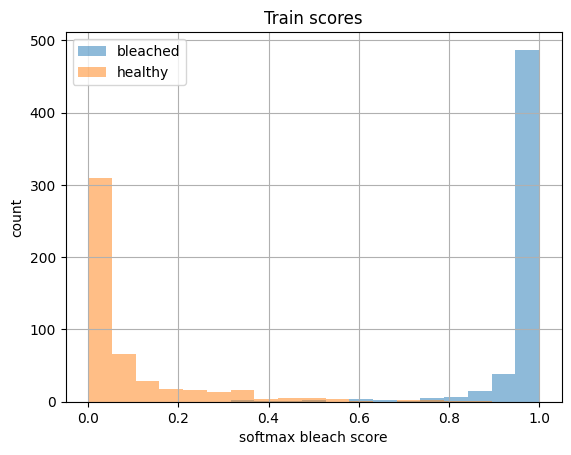

In [21]:
fig, ax = plt.subplots()
train_scores_df.groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True, ax=ax, bins=np.linspace(0,1,20))
ax.set_xlabel('softmax bleach score')
ax.set_xlabel('softmax bleach score')
ax.set_ylabel('count')
ax.set_title('Train scores')


Text(0.5, 1.0, 'Validation scores')

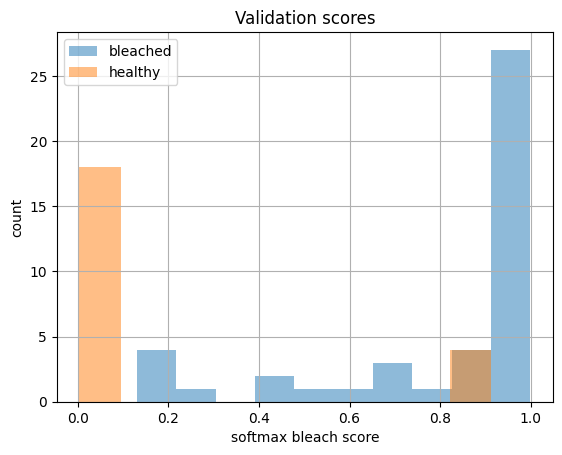

In [6]:
fig, ax = plt.subplots()
val_scores_df.groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True)
ax.set_xlabel('softmax bleach score')
ax.set_ylabel('count')
ax.set_title('Validation scores')

Text(0.5, 1.0, 'Train: North Point Lizard Island')

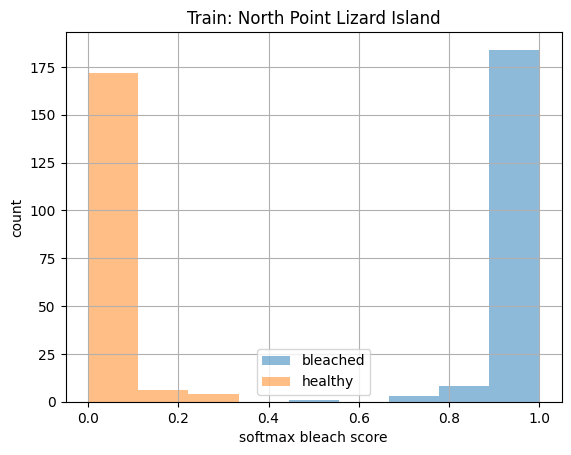

In [18]:
fig, ax = plt.subplots()
train_scores_df[train_scores_df['site']=='northpoint_lizard'].groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True, ax=ax, bins=np.linspace(0,1,10))
ax.set_xlabel('softmax bleach score')
ax.set_xlabel('softmax bleach score')
ax.set_ylabel('count')
ax.set_title('Train: North Point Lizard Island')

Text(0.5, 1.0, 'Validation: North Point Lizard Island')

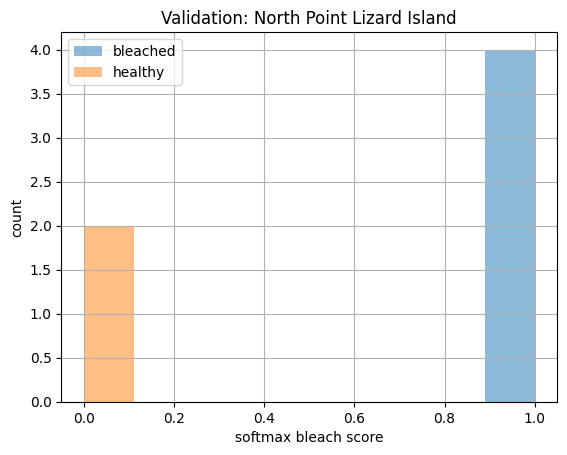

In [16]:
fig, ax = plt.subplots()
val_scores_df[val_scores_df['site']=='northpoint_lizard'].groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True, ax=ax, bins=np.linspace(0,1,10))
ax.set_xlabel('softmax bleach score')
ax.set_ylabel('count')
ax.set_title('Validation: North Point Lizard Island')
#ax.set_xlim([0.975, 1])

Text(0.5, 1.0, 'Train: San Agustin, Mexico')

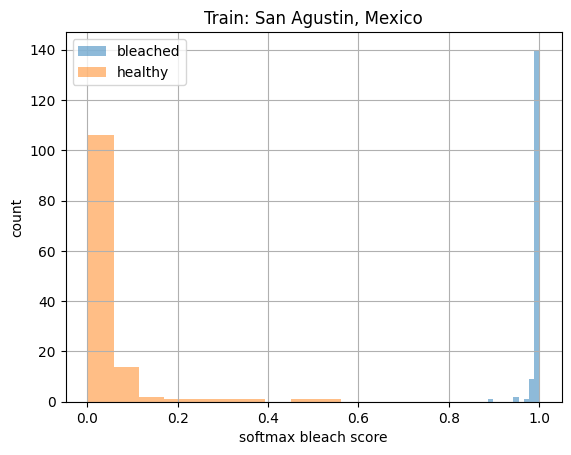

In [9]:
fig, ax = plt.subplots()
train_scores_df[train_scores_df['site']=='sanagustin_mexico'].groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True, ax=ax)
ax.set_xlabel('softmax bleach score')
ax.set_ylabel('count')
ax.set_title('Train: San Agustin, Mexico')

/tmp/ipykernel_745872/259945330.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_scores_df[train_scores_df['site']=='sanagustin_mexico'].groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True, ax=ax)


Text(0.5, 1.0, 'Validation: San Agustin, Mexico')

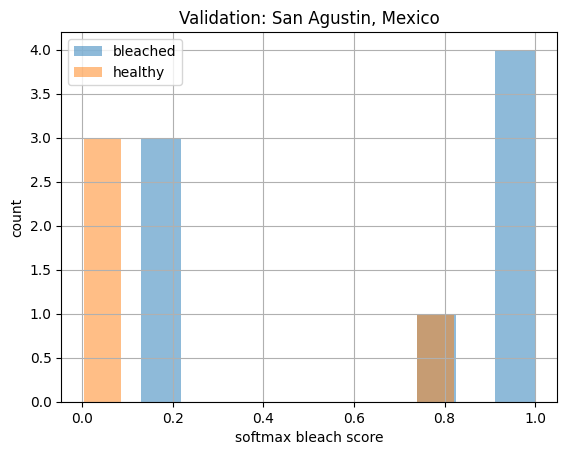

In [10]:
fig, ax = plt.subplots()
val_scores_df[train_scores_df['site']=='sanagustin_mexico'].groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True, ax=ax)
ax.set_xlabel('softmax bleach score')
ax.set_ylabel('count')
ax.set_title('Validation: San Agustin, Mexico')

Text(0.5, 1.0, 'Train: LB Caye, Belize')

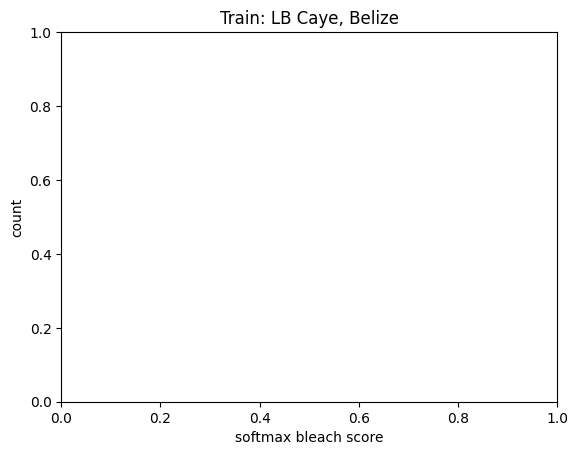

In [11]:
fig, ax = plt.subplots()
train_scores_df[train_scores_df['site']=='lbcaye_bbr'].groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True, ax=ax)
ax.set_xlabel('softmax bleach score')
ax.set_ylabel('count')
ax.set_title('Train: LB Caye, Belize')

Text(0.5, 1.0, 'Validation: LB Caye, Belize')

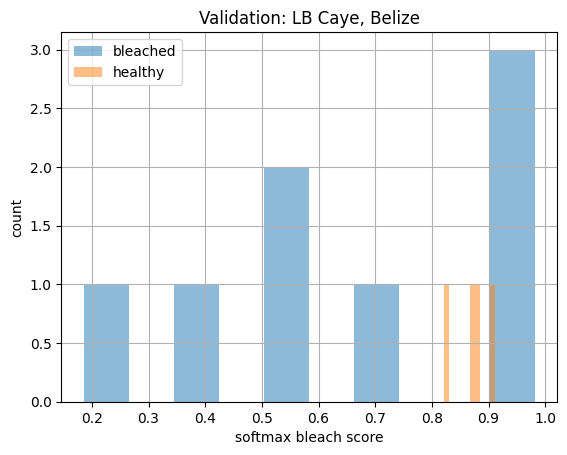

In [12]:
fig, ax = plt.subplots()
val_scores_df[val_scores_df['site']=='lbcaye_bbr'].groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True, ax=ax)
ax.set_xlabel('softmax bleach score')
ax.set_ylabel('count')
ax.set_title('Validation: LB Caye, Belize')

Text(0.5, 1.0, 'Train: Cheeca Rocks, FL Keys')

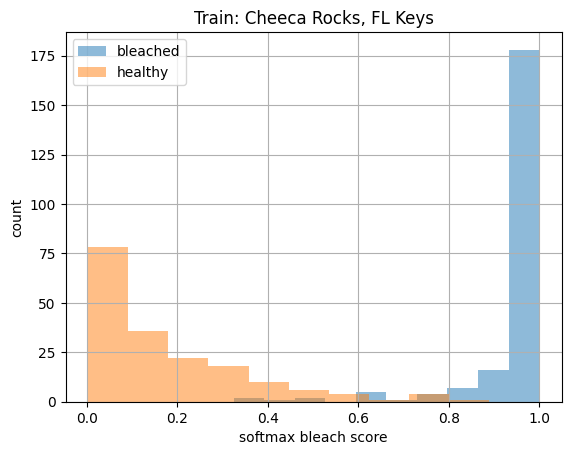

In [13]:
fig, ax = plt.subplots()
train_scores_df[train_scores_df['site']=='cheeca_flkeys'].groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True, ax=ax)
ax.set_xlabel('softmax bleach score')
ax.set_ylabel('count')
ax.set_title('Train: Cheeca Rocks, FL Keys')

Text(0.5, 1.0, 'Validation: Cheeca Rocks, FL Keys')

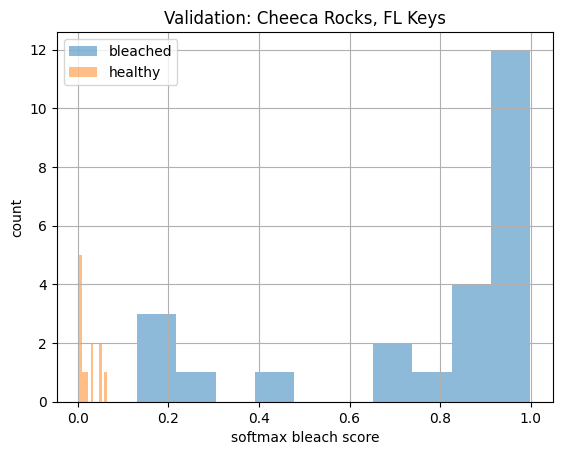

In [14]:
fig, ax = plt.subplots()
val_scores_df[val_scores_df['site']=='cheeca_flkeys'].groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True, ax=ax)
ax.set_xlabel('softmax bleach score')
ax.set_ylabel('count')
ax.set_title('Validation: Cheeca Rocks, FL Keys')

In [22]:
val_scores_df

,image_id1,image_id2,softmax_bleach_scores,raw_bleach_scores,labels,str_labels,image_path1,image_path2,site,filename
0,12,30,0.005895,-2.727152,0.0,healthy,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,cheeca_flkeys,loc005.tif
1,12,54,0.999138,3.349936,1.0,bleached,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,cheeca_flkeys,loc005.tif
2,12,84,0.139361,-0.934251,1.0,bleached,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,cheeca_flkeys,loc005.tif
3,30,12,0.003884,-2.833599,0.0,healthy,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,cheeca_flkeys,loc005.tif
4,30,54,0.998796,3.520177,1.0,bleached,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,cheeca_flkeys,loc005.tif
...,...,...,...,...,...,...,...,...,...,...
61,150,170,0.995178,2.441753,1.0,bleached,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,northpoint_lizard,loc001.tif
62,150,172,0.998412,3.392082,1.0,bleached,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,northpoint_lizard,loc001.tif
63,151,150,0.009384,-2.278242,0.0,healthy,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,northpoint_lizard,loc001.tif
64,151,170,0.995837,2.933374,1.0,bleached,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,northpoint_lizard,loc001.tif


In [25]:
# Predicted labels (using argmax for softmax probabilities)
# y_pred = all_softmax.argmax(axis=1)

# Precision score
# precision = precision_score(val_scores_df['labels'], val_scores_df['softmax_bleach_scores'], average='binary', pos_label=1)
# print("Precision Score (Validation):", precision)
fpr, tpr, thresholds = metrics.roc_curve(val_scores_df['labels'], val_scores_df['softmax_bleach_scores'], pos_label=1)


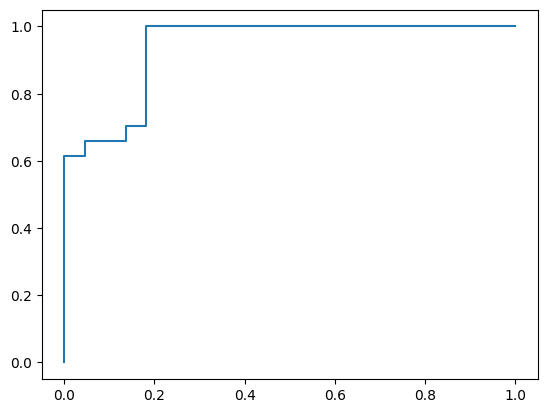

In [27]:
plt.plot(fpr, tpr)

In [29]:
metrics.roc_auc_score(val_scores_df['labels'], val_scores_df['softmax_bleach_scores'])

0.9380165289256198